# Data analysis for Chapter "Global optima and fixed points"

This notebook ....

In [3]:
# importing libraries
from os import getcwd, path
from pathlib import Path

from pandas import Series, DataFrame
import pandas as pd
import numpy as np
from typing import Set, List

from data_analysis_helper_fun import *


In [4]:
# Relevant dirs and file names

# relative path to data directory
data_dir = path.join(Path(getcwd()).parent.absolute(), "data")
data_set_name = 're_data_tau_alpha_01-10'
data_file_name = f'{data_set_name}.tar.gz'

tables_output_dir = path.join(Path(getcwd()).parent.absolute(), "report", "tables")
figures_output_dir = path.join(Path(getcwd()).parent.absolute(), "report", "figures")

## Loading data

In [5]:
re_data = load_re_data(data_dir, data_file_name, filter_erroneous_runs=False)
#display(re_data.columns)

In [6]:
print(f"The data set contains {sum(re_data['error_code'].isna()==False)}/{len(re_data)} rows of erroneous model runs.")
# filter
re_data = re_data.loc[re_data['error_code'].isna()]

The data set contains 0/49111 rows of erroneous model runs.


In [7]:
print('\033[1m' + 'General information: ' + '\033[0m')
print("   Amount of rows:" , len(re_data))
print('   Number of dialectical structures:', len(re_data['ds'].unique()))
print('   Overall number of initial commitments:', len(re_data['init_coms'].unique()))
print('   Sentence-pools:' , re_data['n_sentence_pool'].unique())
print('   Models:' , re_data['model_name'].unique())
print('\n')

General information: 
   Amount of rows: 49111
   Number of dialectical structures: 10
   Overall number of initial commitments: 20
   Sentence-pools: [6]
   Models: ['StandardGlobalReflectiveEquilibrium'
 'StandardGlobalReflectiveEquilibriumLinearG'
 'StandardLocalReflectiveEquilibrium'
 'StandardLocalReflectiveEquilibriumLinearG']




## Non-process perspective 

Here, we analyse the share of global optima among fixed points and the other way around.

We are interested in comparing different models of how the perform w.r.t. reaching global optima. 


Used terminlogy: 

+ An *ensemble* $E$ is the entirety of model runs by varying all specified parameter ranges.
    + Subscripts will denote certain subset within $E$ (e.g., $E_{M_1}$ might denote all models runs with the model $M_1$).
+ One ensemble run, or simulation $e\in E$ corresponds to one model run with a specified set of parameters (including all branches that might evolve in the process).
+ $B_e$ is the set of branches in $e$ and $b\in B_e$ denotes one specific branch in an ensemble run $e$.
+ $GO_e$ is the set of all global optima of an ensemble run.
+ $FP_e$ is the set of all fixed points (end points) of branches in $B_e$.
+ $FPGO$ (fixed-point global optima) is the set of fixed points in $e$ that are at the same time global optima ($GO_e \cap FP_e$).


### Table XX

Here we calculate

$$
\vert FPGO_m\vert/ \vert GO_m\vert := \frac{\sum_{e\in E_{m}}\vert FPGO_e\vert}{\sum_{e\in E}\vert GO_e\vert}
$$

as the overall share of fixped-point global optima among all global optima and

$$
\vert FPGO_m\vert/ \vert FP_m\vert := \frac{\sum_{e\in E_{m}}\vert FPGO_e\vert}{\sum_{e\in E}\vert FP_e\vert}
$$

as the overall share of fixped-point global optima among all fixied points for all model variations $m$.

In [8]:
# We want to summarise branches that belong to one ensemble run (i.e., to one set of initial coms, model name etc.)
# into one row.
# Basic idea by using data_frame.duplicate:
# We remove duplicate rows (and keep the first one) of the subdataframe of those cols with identical values that make up branches 
# that belong together and pick the first element of the remaining cols (which should be the same for all 
# cols that matte for subsequent calculations). We then use the resulting (unchanged) index to subset the whole data frame.

# Cols that should have identical values for all branches (and only for those) that belong to one branching model run
cols_group_branches = ['model_name','ds','init_coms','weight_account', 'weight_systematicity', 'weight_faithfulness'] 

#relevant_cols = ['fixed_points','fixed_point_coms', 'global_optima','go_fixed_point']

re_data_collapsed_branches = re_data.loc[re_data[cols_group_branches].drop_duplicates().index]


In [9]:
# number of go that are fp for each model run
re_data_collapsed_branches['n_fpgo'] = re_data_collapsed_branches.apply(lambda x: sum(x['go_fixed_point']) , axis=1)

# just to check: should be the same values as 'n_go_fixed_point'
re_data_collapsed_branches['n_fpgo2'] = re_data_collapsed_branches.apply(lambda x: sum(x['fp_global_optimum']) , axis=1)


#display(re_data_collapsed_branches[relevant_cols])

# aggregate values among models
agg_funs = {
    'n_branches': 'sum',
    'n_fixed_points': 'sum',
    'n_global_optima': 'sum',
    'n_fpgo': 'sum',
    'n_fpgo2': 'sum'
}

result_df = re_data_collapsed_branches.groupby('model_name').agg(agg_funs).reset_index()

# calcualte relative shares
# relative share of fixed point/reached gos among all global optima (in %)
result_df['rel_fpgo_fp'] = result_df.apply(lambda x: x['n_fpgo']/x['n_global_optima']*100, axis=1)
# relative share of fixed point/reached gos among all fixed points (in %)
result_df['rel_fpgo_go'] = result_df.apply(lambda x: x['n_fpgo']/x['n_fixed_points']*100, axis=1)
display(result_df)

# Preparing the dataframe for csv export
model_short_names = {'StandardGlobalReflectiveEquilibrium':'QuadraticGlobalRE',
                     'StandardLocalReflectiveEquilibrium':'QuadraticLocalRE',
                     'StandardGlobalReflectiveEquilibriumLinearG': 'LinearGlobalRE',
                     'StandardLocalReflectiveEquilibriumLinearG': 'LinearLocalRE'
                    }
# Adding model short names
result_df['model_short_name'] = result_df['model_name'].map(lambda x: model_short_names[x])

# Changing col names for readability
cols_for_tables = {'model_short_name':'Model',
                   'rel_fpgo_fp': '% of fixed points in global optima',
                   'rel_fpgo_go': '% of global optima in fixed points',
                  }
#display(result_df.rename(columns=cols_for_tables))
# Exporting relevant cols

result_df[['model_short_name','rel_fpgo_fp','rel_fpgo_go']].rename(columns=cols_for_tables).to_csv(path.join(tables_output_dir, 'table_go_fp.csv'), index=False)

,model_name,n_branches,n_fixed_points,n_global_optima,n_fpgo,n_fpgo2,rel_fpgo_fp,rel_fpgo_go
0,StandardGlobalReflectiveEquilibrium,10822,10560,17986,8409,8409,46.753030,79.630682
1,StandardGlobalReflectiveEquilibriumLinearG,9722,9721,16870,7539,7539,44.688797,77.553750
2,StandardLocalReflectiveEquilibrium,15436,10922,17986,7256,7256,40.342489,66.434719
3,StandardLocalReflectiveEquilibriumLinearG,13131,8036,16870,5917,5917,35.074096,73.631160


### Venn Diagramms (Figure XX)

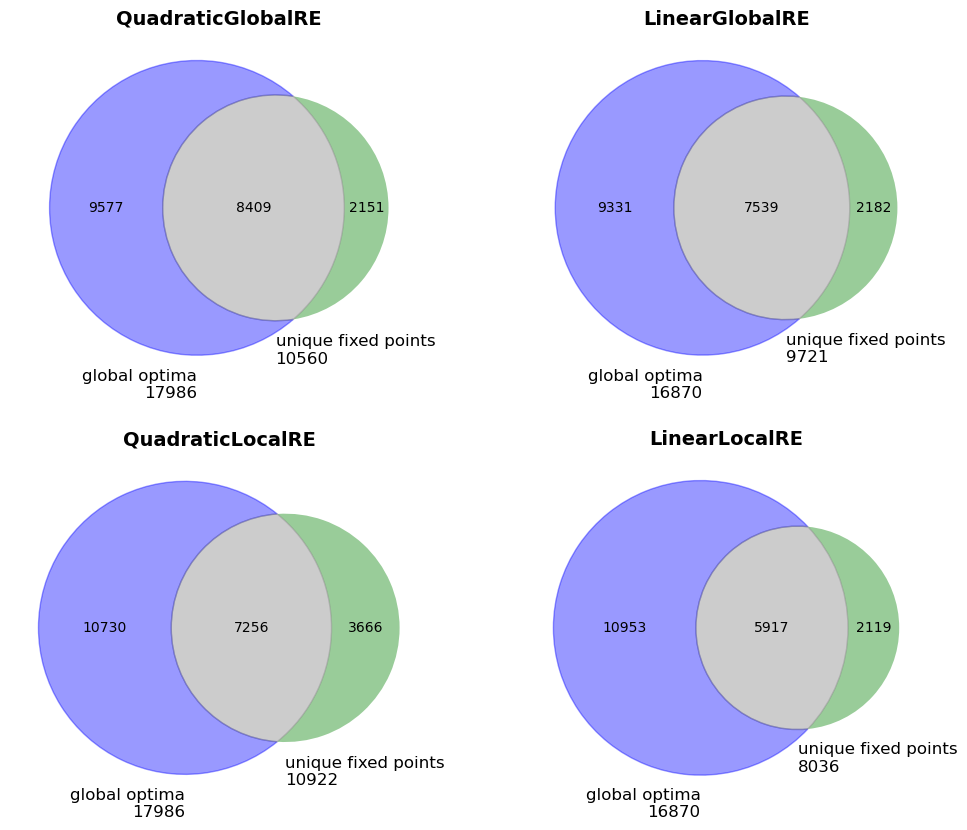

In [10]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn2

plt.rcParams["figure.figsize"] = (12,10)
#plt.suptitle("Share of global optima and fixed points")

for i, row in result_df.iterrows():

    plt.subplot(2,2,i+1)

    tup = (row["n_global_optima"]-row["n_fpgo"], row["n_fixed_points"]-row["n_fpgo"], row["n_fpgo"])

    v = venn2(tup, ("global optima" + '\n' + str(row["n_global_optima"]), 
                "unique fixed points" + '\n' + str(row["n_fixed_points"])))

    v.get_patch_by_id('10').set_color("b")
    v.get_patch_by_id('11').set_color("grey")

    plt.title(row["model_short_name"], fontweight='bold', fontsize=14)

plt.savefig(path.join(figures_output_dir, 'go-fp-venn.pdf'), bbox_inches='tight')
plt.savefig(path.join(figures_output_dir, 'go-fp-venn.png'), bbox_inches='tight')

plt.show()

### Heat Maps

For understanding the role of $\alpha$-weights for reaching global optima, we calculate for each ensemble $e$ the relative share of  fixed-point global optima ($\frac{\vert FPGO_e\vert}{\vert GO_e\vert}$ and $\frac{\vert FPGO_e\vert}{\vert FP_e\vert}$ respectively), and then aggregate over model model runs with the same $\alpha$-weight configuration. The heat map display means and standard deviations (to check) for each such configuartion. 

Note that these relative numbers mean sth. different than the aggregated relative numbers from above. In particular, the mean of these means aggregated of all weight configurations for a specific model are different from the above calculated numbers (TO CHECK).

For instance:
$$
\vert FPGO_m\vert/ \vert GO_m\vert \neq \frac{1}{\vert E_m \vert} \sum_{e\in E_m} \frac{\vert FPGO_e\vert}{\vert GO_e\vert}
$$

In [11]:
# relative number of go that are fp among all global optima (in %)
re_data_collapsed_branches['rel_fpgo_go'] = re_data_collapsed_branches.apply(lambda x: x['n_fpgo']/x['n_global_optima']*100, axis=1)
# relative number of go that are fp among all fixed points (in %)
re_data_collapsed_branches['rel_fpgo_fp'] = re_data_collapsed_branches.apply(lambda x: x['n_fpgo']/x['n_fixed_points']*100, axis=1)


In [12]:
# here, we can see the difference in numbers (compare to the table from above)
result_df = re_data_collapsed_branches.groupby('model_name').agg({'rel_fpgo_go':'mean'}).reset_index()
display(result_df)

,model_name,rel_fpgo_go
0,StandardGlobalReflectiveEquilibrium,63.269020
1,StandardGlobalReflectiveEquilibriumLinearG,60.418206
2,StandardLocalReflectiveEquilibrium,56.717619
3,StandardLocalReflectiveEquilibriumLinearG,54.279321


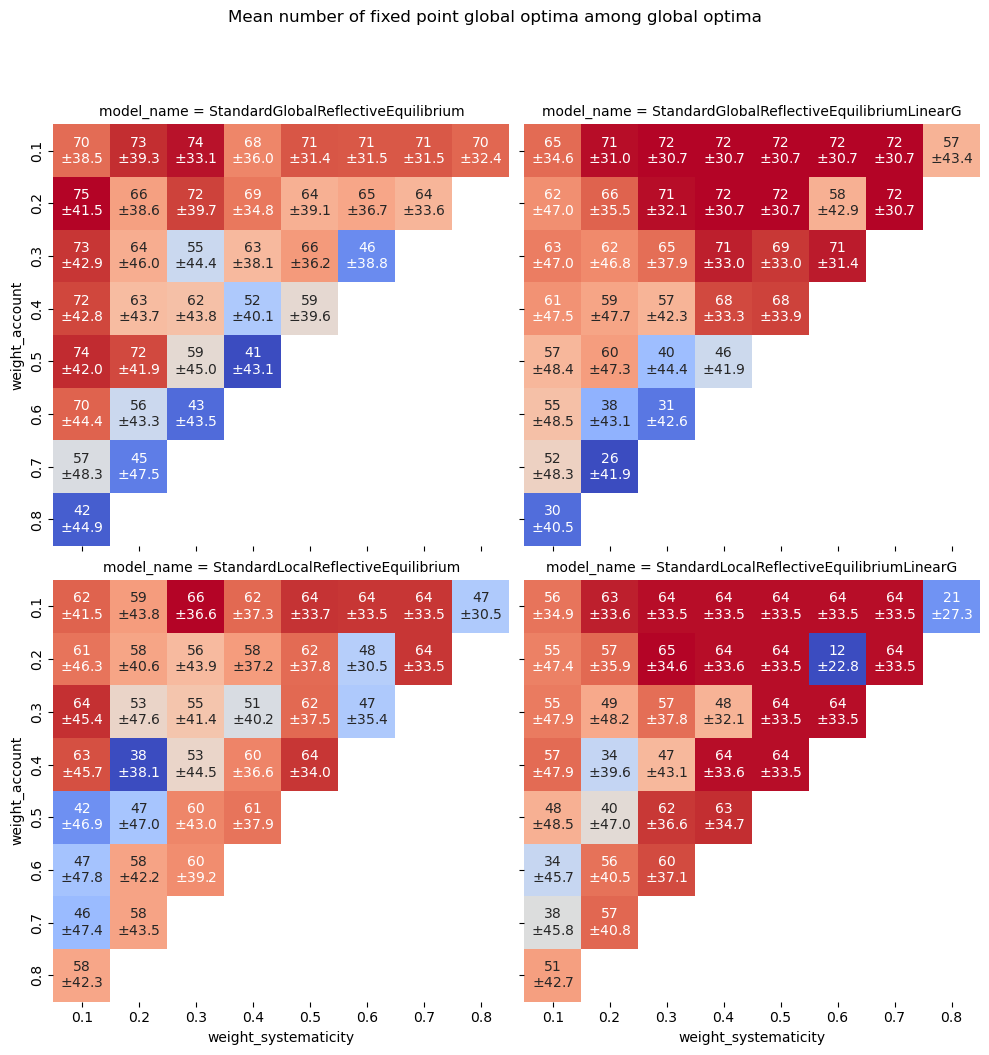

In [13]:
from restudies.notebook_util import simple_heatmap_plot, heatmap_plot, heat_maps_by_weights, reproduce_re_process, evolution_data

heat_maps_by_weights(re_data = re_data_collapsed_branches, values = 'rel_fpgo_go', 
                         title = 'Mean number of fixed point global optima among global optima', 
                         annot_std = True, annot_std_fmt = r'$\pm${:2.1f}')

## Process perspective

Here, we analyse the process by asking:

How often does the process end up in global optima (in relation all global optima and in relation to all branches)? (In other words, how many branches end up in global optima.)


### Table XX

In [14]:
#display(re_data[['model_name','fixed_point_is_global_optimum']].head())
# sum: number of go that are reached by processes (branches)
# size: number of branches

result_df = re_data[['model_name','fixed_point_is_global_optimum']].groupby(['model_name']).agg(['sum','size'])
# renaming
result_df.columns = ['n_go_branches','n_branches']

# get the overal number of global optima from the branch-collapsed df 
result_df['n_global_optima'] = re_data_collapsed_branches[['model_name', 'n_global_optima']].groupby('model_name').agg('sum')

# calculate relative values
# share of reached gos in all gos (in %)
result_df['rel_go_all_go'] = result_df.apply(lambda x: x['n_go_branches']/x['n_global_optima']*100, axis=1)
# share of reached gos in all branches (in %)
result_df['rel_go_all_branches'] = result_df.apply(lambda x: x['n_go_branches']/x['n_branches']*100, axis=1)
# reindex
result_df = result_df.reset_index()

# Adding model short names
result_df['model_short_name'] = result_df['model_name'].map(lambda x: model_short_names[x])

display(result_df)

# Changing col names for readability
cols_for_tables = {'model_short_name':'Model',
                   'rel_go_all_go': '% of reached global optima in global optima',
                   'rel_go_all_branches': '% of reached global optima in all branches',
                  }
# display(result_df.rename(columns=cols_for_tables))
# Exporting relevant cols

result_df[['model_short_name','rel_go_all_go','rel_go_all_branches']].rename(columns=cols_for_tables).to_csv(path.join(tables_output_dir, 'table_go_branches.csv'), index=False)

,model_name,n_go_branches,n_branches,n_global_optima,rel_go_all_go,rel_go_all_branches,model_short_name
0,StandardGlobalReflectiveEquilibrium,8620,10822,17986,47.926165,79.652560,QuadraticGlobalRE
1,StandardGlobalReflectiveEquilibriumLinearG,7540,9722,16870,44.694724,77.556058,LinearGlobalRE
2,StandardLocalReflectiveEquilibrium,10869,15436,17986,60.430335,70.413320,QuadraticLocalRE
3,StandardLocalReflectiveEquilibriumLinearG,10141,13131,16870,60.112626,77.229457,LinearLocalRE


### Venn Diagramms (Figure XX)

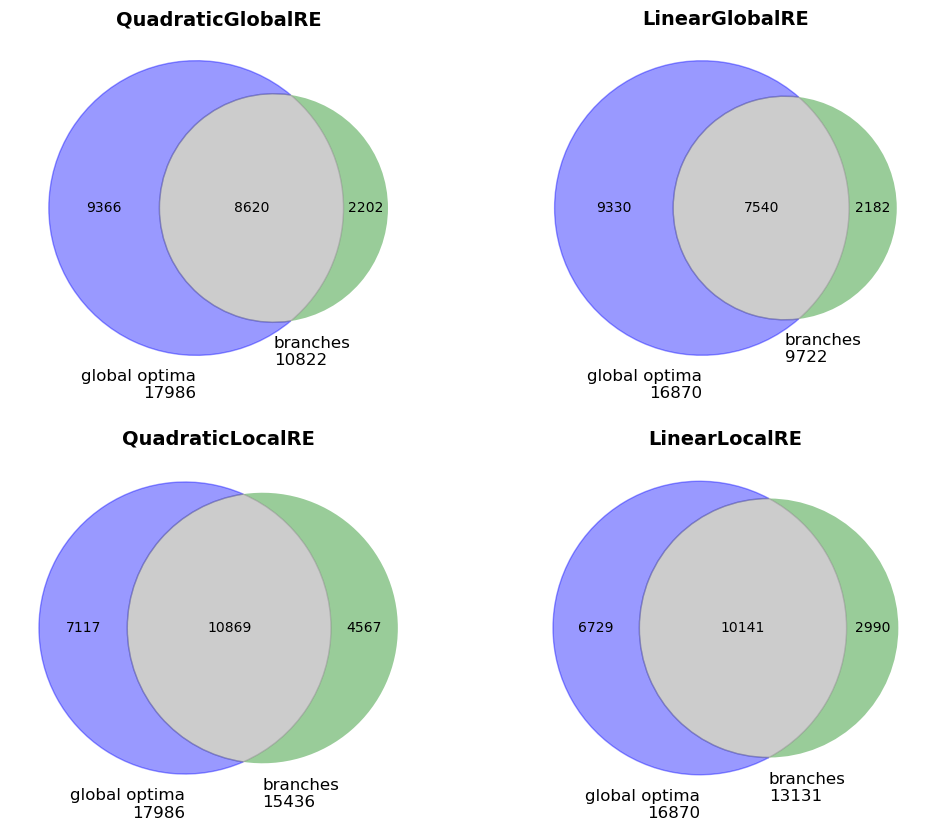

In [15]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn2

plt.rcParams["figure.figsize"] = (12,10)
#plt.suptitle("Share of global optima and fixed points")

for i, row in result_df.iterrows():

    plt.subplot(2,2,i+1)

    tup = (row["n_global_optima"]-row["n_go_branches"], row["n_branches"]-row["n_go_branches"], row["n_go_branches"])

    v = venn2(tup, ("global optima" + '\n' + str(row["n_global_optima"]), 
                "branches" + '\n' + str(row["n_branches"])))

    v.get_patch_by_id('10').set_color("b")
    v.get_patch_by_id('11').set_color("grey")

    plt.title(row["model_short_name"], fontweight='bold', fontsize=14)

plt.savefig(path.join(figures_output_dir, 'go-branches-venn.pdf'), bbox_inches='tight')
plt.savefig(path.join(figures_output_dir, 'go-branches-venn.png'), bbox_inches='tight')

plt.show()

## Deprecated (to be removed later on)

In [102]:
# The original suggestion to calculate mean number of fixed point among go, which has a double counting problem due to
# the multiplicity of branches. 

# Is this correct? What about the multiplicity due to branching? The possible double-counting wouldn't matter 
# only if there is always the same number of branches, right? 
re_data['rel_global_optima_that_are_fixed_points'] = re_data['go_fixed_point'].map(sum)/re_data['go_fixed_point'].map(len)
print('In', len(re_data[re_data['rel_global_optima_that_are_fixed_points'] == 1]),
      'out of', len(re_data),'(=', "{:2.1f}".format( len(re_data[re_data['rel_global_optima_that_are_fixed_points'] == 1])/len(re_data)*100),
      '%) processes are all global optima fixed points.')

print('\n')
print("Mean relative share of global optima that are fixed points:")
display(re_data.groupby(['model_name']).mean()[['rel_global_optima_that_are_fixed_points']])


In 107 out of 197 (= 54.3 %) processes are all global optima fixed points.


Mean relative share of global optima that are fixed points:


/tmp/ipykernel_452939/2460446498.py:10: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  display(re_data.groupby(['model_name']).mean()[['rel_global_optima_that_are_fixed_points']])


,rel_global_optima_that_are_fixed_points
model_name,
GlobalNumpyReflectiveEquilibrium,0.885714
LocalStandardReflectiveEquilibrium,0.118056
StandardGlobalReflectiveEquilibriumLinearG,0.955009
StandardLocalReflectiveEquilibriumLinearG,0.066667


In [103]:
# Alternative suggestion to summarise branches that belong to the same branching model run (instead of using df.duplicate)
# Idea: groupby cols that "individuate" branches that belong to the same model run

cols_group_branches = ['model_name','ds','init_coms','weight_account', 'weight_systematicity', 'weight_faithfulness'] 
relevant_cols = ['fixed_points','fixed_point_coms', 'global_optima','go_fixed_point']
#tmp = re_data.groupby(cols_group_branches).agg(lambda x: len(set(x)) <= 1)
#tmp = re_data.groupby(cols_group_branches)[relevant_cols].agg(lambda x: set(x))
#display(tmp.columns)
#display(tmp.head())

# A:
# Idea: We group row according to those cols that individuate branches that belong together and pick the first
# elelement of the remaining cols (which should be the same for all cols that matte for subsequent calculations).
re_data_group_branches = re_data.groupby(cols_group_branches)[relevant_cols].agg(lambda x: list(x)[0])
#display(re_data_group_branches.reset_index()[relevant_cols])
#display(re_data_group_branches.reset_index()[['fixed_points', 'global_optima']])


# The calculation is the same as in the original suggestion:
re_data_group_branches['rel_global_optima_that_are_fixed_points'] = re_data_group_branches['go_fixed_point'].map(sum)/re_data_group_branches['go_fixed_point'].map(len)
print('In', len(re_data_group_branches[re_data_group_branches['rel_global_optima_that_are_fixed_points'] == 1]),
      'out of', len(re_data_group_branches),'(=', "{:2.1f}".format( len(re_data_group_branches[re_data_group_branches['rel_global_optima_that_are_fixed_points'] == 1])/len(re_data)*100),
      '%) processes are all global optima fixed points.')

print('\n')
print("Mean relative share of global optima that are fixed points:")
display(re_data_group_branches.groupby(['model_name']).mean()[['rel_global_optima_that_are_fixed_points']])

In 18 out of 48 (= 9.1 %) processes are all global optima fixed points.


Mean relative share of global optima that are fixed points:


/tmp/ipykernel_452939/3144989660.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  display(re_data_group_branches.groupby(['model_name']).mean()[['rel_global_optima_that_are_fixed_points']])


,rel_global_optima_that_are_fixed_points
model_name,
GlobalNumpyReflectiveEquilibrium,0.863095
LocalStandardReflectiveEquilibrium,0.076389
StandardGlobalReflectiveEquilibriumLinearG,0.722553
StandardLocalReflectiveEquilibriumLinearG,0.083333
